# Sarcasm Article prediction

## 1. Importing modules

In [1]:
# Resource url:
# https://www.youtube.com/watch?v=6lMQnaFS3Rc
# https://www.youtube.com/watch?v=Y_hzMnRXjhI&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=3
# https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb#scrollTo=BQVuQrZNkPn9
# wget --no-check-certificate https://storage.googleapis.com/learning-datasets/sarcasm.json -O ./tmp/sarcasm.json
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [2]:

import tensorflow as tf
import matplotlib.pyplot as plt
import json
import math

## 2. Loading data from json file

In [3]:

# Training section
with open("../data/sarcasm.json", "r") as file:
    datastore = json.load(file)

sentences = []
labels = []

for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 20000

# sentence len 26709

## 3. Split training size and label

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## 4. Tokenization

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, oov_token=oov_tok
)
# Tokenize the text
tokenizer.fit_on_texts(training_sentences[:training_size])

word_index = tokenizer.word_index

# Turn the training text to sequence
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    training_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)

In [7]:
# Need this block to get it to work with TensorFlow 2.x
# convert "list" (Nth dimesion arrat) to "NDArray" using numpy library
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## 5. Training the model

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
num_epochs = 30
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    verbose=2,
)

Epoch 1/30


625/625 - 1s - loss: 0.6741 - accuracy: 0.5705 - val_loss: 0.6226 - val_accuracy: 0.6430 - 1s/epoch - 2ms/step
Epoch 2/30
625/625 - 1s - loss: 0.4678 - accuracy: 0.8111 - val_loss: 0.4014 - val_accuracy: 0.8274 - 751ms/epoch - 1ms/step
Epoch 3/30
625/625 - 1s - loss: 0.3277 - accuracy: 0.8689 - val_loss: 0.3602 - val_accuracy: 0.8487 - 754ms/epoch - 1ms/step
Epoch 4/30
625/625 - 1s - loss: 0.2725 - accuracy: 0.8949 - val_loss: 0.3484 - val_accuracy: 0.8521 - 758ms/epoch - 1ms/step
Epoch 5/30
625/625 - 1s - loss: 0.2374 - accuracy: 0.9077 - val_loss: 0.3453 - val_accuracy: 0.8538 - 758ms/epoch - 1ms/step
Epoch 6/30
625/625 - 1s - loss: 0.2087 - accuracy: 0.9194 - val_loss: 0.3458 - val_accuracy: 0.8574 - 758ms/epoch - 1ms/step
Epoch 7/30
625/625 - 1s - loss: 0.1864 - accuracy: 0.9290 - val_loss: 0.3616 - val_accuracy: 0.8506 - 750ms/epoch - 1ms/step
Epoch 8/30
625/625 - 1s - loss: 0.1692 - accuracy: 0.9359 - val_loss: 0.3705 - val_accuracy: 0.8517 - 754ms/epoch - 1ms/step
E

## 6. Create the graph for better understanding

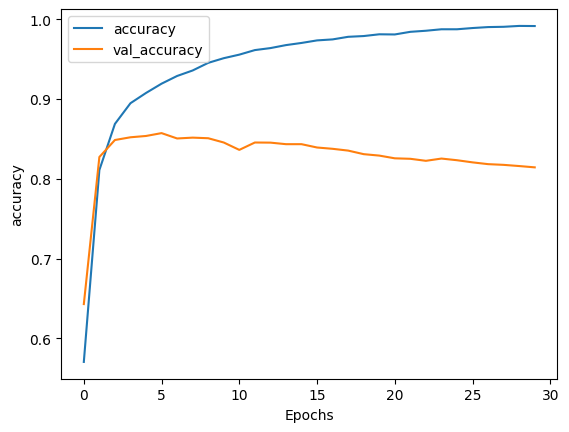

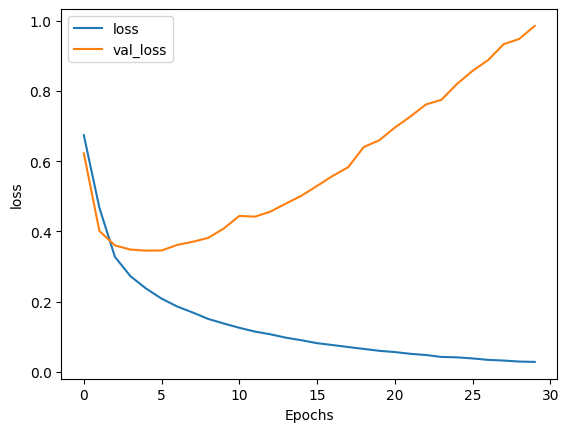

DECODE sentence
former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Original sentence
former versace store clerk sues over secret 'black code' for minority shoppers
Is_sarcasm:
0
[[ 1.2053059e-02 -5.8799633e-03  1.1445944e-01 ...  3.5848793e-02
   6.7748539e-02  4.1742440e-02]
 [ 2.5515828e-02 -2.2670608e-03  5.5476371e-02 ...  1.1232260e-01
   7.4223958e-02 -1.9232905e-02]
 [-5.9200719e-02  9.2788987e-02 -3.0695758e-04 ...  1.5991582e-01
   9.8662265e-02 -3.2726225e-02]
 ...
 [ 4.3179622e-01 -4.1988662e-01  4.4407299e-01 ... -4.5288625e-01
  -4.4040474e-01  4.4087160e-01]
 [-2.6231074e-01  2.8860176e-01 -1.2622130e-01 ...  2.7769268e-01
   1.7958790e-01 -1.6504744e-01]
 [-4.3971273e-01  4.7448748e-01 -3.4866995e-01 ...  4.5604077e-01
   4.3880448e-01 -4.0345907e-01]]


In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, str):
    plt.plot(history.history[str])
    plt.plot(history.history["val_" + str])
    plt.xlabel("Epochs")
    plt.ylabel(str)
    plt.legend([str, "val_" + str])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# decode the word index back to original word
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentences(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

print("DECODE sentence")
print(decode_sentences(training_padded[0]))
print("Original sentence")
print(training_sentences[0])
print("Is_sarcasm:")
print(labels[0])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights)  # shape: (vocab_size, embedding_dim)

## 7. Saving the model

In [11]:
# Saving the whole model
# HDF5 format
model.save("nn.h5")
# Saving only weight
model.save_weights("nn_weight.h5")
# Saving only the architecture
json_str = model.to_json()
with open("nn_model.json","w") as f:
    f.write(json_str)

d:\#Code\My Project\Test\JupiterNotebook\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 66ms/step
[[9.8697525e-01]
 [7.3364041e-05]]


## 8. Predict data using pre-trained model

In [10]:

# Data to predict
sentences = [
    "granny starting to fear spiders in the garden might be real",
    "game of thrones season finale showing this sunday night",
]

pretrain_model = tf.keras.models.load_model("nn.h5")
pretrain_model.summary()

sequences = tokenizer.texts_to_sequences(sentences)
padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)
print(pretrain_model.predict(padded))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 45ms/step
[[9.8697525e-01]
 [7.3364041e-